# Task 7 · Statistical Time-Series Models (ARIMA/SARIMA)

This notebook fits and evaluates ARIMA/SARIMA models for the household demand series, providing diagnostics, evaluation metrics, and artefacts for both the LaTeX report and the interactive dashboard.

In [2]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Project imports
ROOT = Path.cwd().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Matplotlib styling
mpl.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'semibold',
    'axes.grid': True,
    'grid.color': '#d9d9d9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'font.family': 'DejaVu Sans',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
})

COLORS = {
    'actual': '#1f77b4',
    'arima': '#2ca02c',
    'sarima1': '#FFA500',
    'sarima2': '#d62728',
    'confidence': '#87CEEB',
}

In [3]:
pd.options.display.max_rows = 12

# Define paths for input data and output artefacts
FIG_PATH = ROOT / "reports" / "figures"
TABLE_PATH = ROOT / "reports" / "tables"
DATA_PATH = ROOT / "data" / "raw" / "train_252145.csv"

# Ensure output directories exist
FIG_PATH.mkdir(parents=True, exist_ok=True)
TABLE_PATH.mkdir(parents=True, exist_ok=True)


def save_figure(fig, name: str, dpi: int = 300) -> None:
    """
    Save a Matplotlib figure to PNG format only.
    """
    png = FIG_PATH / f"{name}.png"
    fig.savefig(str(png), dpi=dpi, bbox_inches='tight', facecolor='white')
    print(f"Saved: {png}")


# Load and preprocess the dataset
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"]).sort_values("timestamp")
df["Demand"] = pd.to_numeric(df["Demand"], errors="coerce")
df = df.dropna(subset=["Demand"]).set_index("timestamp").sort_index()

# Resample to hourly cadence to guarantee regularity (fill gaps via interpolation)
hourly_demand = df["Demand"].resample("h").mean().interpolate(method="time", limit_direction="both").dropna()
demand_df = hourly_demand.reset_index().rename(columns={"timestamp": "timestamp", "Demand": "Demand"})

print(
    f"Demand sample: {demand_df['timestamp'].min()} → {demand_df['timestamp'].max()} | "
    f"Observations: {len(demand_df):,}"
)
display(demand_df.head())

Demand sample: 2013-07-01 00:00:00+00:00 → 2014-06-30 23:00:00+00:00 | Observations: 8,760


,timestamp,Demand
0,2013-07-01 00:00:00+00:00,0.27
1,2013-07-01 01:00:00+00:00,0.23
2,2013-07-01 02:00:00+00:00,0.26
3,2013-07-01 03:00:00+00:00,0.28
4,2013-07-01 04:00:00+00:00,0.29


## Stationarity diagnostics

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Stationarity Tests: ADF and KPSS
# ─────────────────────────────────────────────────────────────────────────────
def run_stationarity_tests(series: pd.Series) -> pd.DataFrame:
    """Run ADF and KPSS tests on a time series."""
    # ADF Test (H0: series has a unit root, i.e., non-stationary)
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series.dropna(), autolag='AIC')
    
    # KPSS Test (H0: series is stationary)
    kpss_stat, kpss_p, _, kpss_crit = kpss(series.dropna(), regression='c', nlags='auto')
    
    results = pd.DataFrame({
        'Test': ['ADF', 'KPSS'],
        'Statistic': [adf_stat, kpss_stat],
        'p-value': [adf_p, kpss_p],
        'Critical 5%': [adf_crit['5%'], kpss_crit['5%']],
        'Conclusion': [
            'Stationary' if adf_p < 0.05 else 'Non-Stationary',
            'Stationary' if kpss_p > 0.05 else 'Non-Stationary'
        ]
    })
    return results

# Run stationarity tests on original demand series
print("Stationarity Tests on Original Demand Series:")
stationarity_orig = run_stationarity_tests(hourly_demand)
display(stationarity_orig)

# Apply first-order differencing to achieve stationarity
demand_diff = hourly_demand.diff().dropna()
print("\nStationarity Tests on First-Differenced Demand:")
stationarity_diff = run_stationarity_tests(demand_diff)
display(stationarity_diff)

# Save combined stationarity results
stationarity_combined = pd.concat([
    stationarity_orig.assign(Series='Original'),
    stationarity_diff.assign(Series='Differenced')
], ignore_index=True)
stationarity_combined.to_csv(TABLE_PATH / "stationarity_tests.csv", index=False)

Stationarity Tests on Original Demand Series:


,Test,Statistic,p-value,Critical 5%,Conclusion
0,ADF,-11.773439,1.076326e-21,-2.861871,Stationary
1,KPSS,1.227158,1.000000e-02,0.463000,Non-Stationary



Stationarity Tests on First-Differenced Demand:


,Test,Statistic,p-value,Critical 5%,Conclusion
0,ADF,-24.629138,0.0,-2.861871,Stationary
1,KPSS,0.029878,0.1,0.463000,Stationary


Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/07_acf_pacf.png


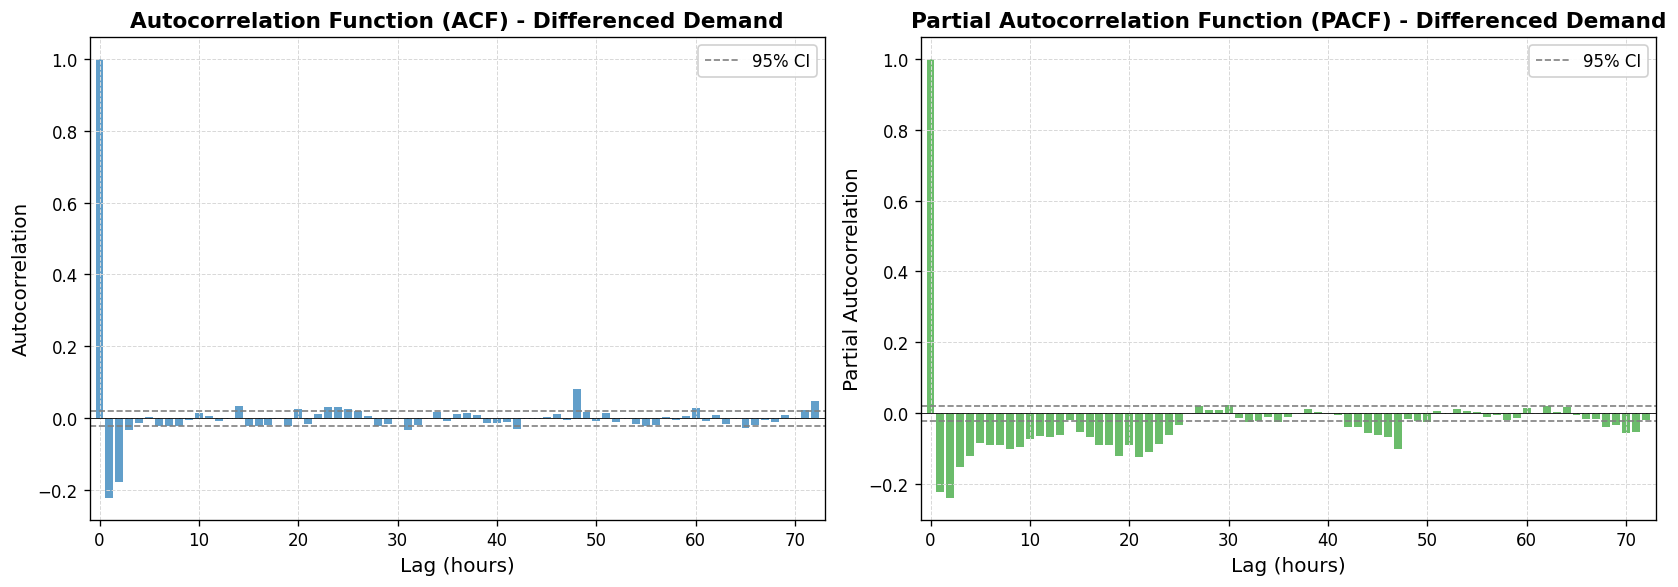

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# ACF and PACF Analysis
# ─────────────────────────────────────────────────────────────────────────────
nlags = 72

# Compute ACF and PACF on differenced series
acf_vals = acf(demand_diff, nlags=nlags, fft=True)
pacf_vals = pacf(demand_diff, nlags=nlags, method='ywm')

# Create ACF/PACF plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
ax1 = axes[0]
ax1.bar(range(len(acf_vals)), acf_vals, color=COLORS['actual'], alpha=0.7, width=0.8)
# Confidence interval (95%)
ci = 1.96 / np.sqrt(len(demand_diff))
ax1.axhline(y=ci, color='gray', linestyle='--', linewidth=1, label='95% CI')
ax1.axhline(y=-ci, color='gray', linestyle='--', linewidth=1)
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.set_xlabel('Lag (hours)', fontsize=12)
ax1.set_ylabel('Autocorrelation', fontsize=12)
ax1.set_title('Autocorrelation Function (ACF) - Differenced Demand', fontsize=13, fontweight='semibold')
ax1.set_xlim(-1, nlags + 1)
ax1.legend(loc='upper right')

# PACF plot
ax2 = axes[1]
ax2.bar(range(len(pacf_vals)), pacf_vals, color=COLORS['arima'], alpha=0.7, width=0.8)
ax2.axhline(y=ci, color='gray', linestyle='--', linewidth=1, label='95% CI')
ax2.axhline(y=-ci, color='gray', linestyle='--', linewidth=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Lag (hours)', fontsize=12)
ax2.set_ylabel('Partial Autocorrelation', fontsize=12)
ax2.set_title('Partial Autocorrelation Function (PACF) - Differenced Demand', fontsize=13, fontweight='semibold')
ax2.set_xlim(-1, nlags + 1)
ax2.legend(loc='upper right')

plt.tight_layout()
save_figure(fig, "07_acf_pacf")
plt.show()


## Candidate Model Definitions

I explore one non-seasonal ARIMA configuration and two seasonal SARIMA variants motivated by the daily cycle (s = 24). Seasonal differencing is set to D = 1 where required to address residual daily seasonality.

In [6]:
# Import modeling functions from project modules
from src.modeling_stats import fit_arima, forecast_arima, evaluate_forecast, walk_forward_daily

# Define candidate ARIMA/SARIMA models
# I test a non-seasonal ARIMA and two seasonal SARIMA configurations
MODEL_CANDIDATES = [
    {
        "name": "ARIMA(2,1,2)",
        "order": (2, 1, 2),
        "seasonal_order": (0, 0, 0, 0),
    },
    {
        "name": "SARIMA(1,1,1)(1,1,1,24)",
        "order": (1, 1, 1),
        "seasonal_order": (1, 1, 1, 24),
    },
    {
        "name": "SARIMA(2,1,1)(0,1,1,24)",
        "order": (2, 1, 1),
        "seasonal_order": (0, 1, 1, 24),
    },
]

# Define forecast parameters
forecast_horizon = 24
validation_window_hours = 24

# Define train/validation split (hold out the last 7 days for final validation)
validation_cutoff = demand_df["timestamp"].max() - pd.Timedelta(days=7)
train_mask = demand_df["timestamp"] < validation_cutoff
val_mask = (demand_df["timestamp"] >= validation_cutoff) & (
    demand_df["timestamp"] < validation_cutoff + pd.Timedelta(hours=validation_window_hours)
)

train_series = demand_df.loc[train_mask].set_index("timestamp")["Demand"]
validation_df = demand_df.loc[val_mask].copy()

print(f"Training samples: {len(train_series):,}; validation horizon: {len(validation_df)}")
print(f"\nModel candidates to evaluate:")
for m in MODEL_CANDIDATES:
    print(f"  - {m['name']}")

Training samples: 8,591; validation horizon: 24

Model candidates to evaluate:
  - ARIMA(2,1,2)
  - SARIMA(1,1,1)(1,1,1,24)
  - SARIMA(2,1,1)(0,1,1,24)


## Whole-Training Split Evaluation

This validation approach uses all available training data up to a fixed cutoff point, then evaluates the 24-hour forecast accuracy. While computationally efficient, this single-split approach may not fully capture model robustness.

In [7]:
single_split_records = []
single_split_predictions = []

# Iterate over each candidate model
for candidate in MODEL_CANDIDATES:
    print(f"Fitting {candidate['name']}...")
    
    # Fit the model on the training series
    result = fit_arima(train_series, order=candidate["order"], seasonal_order=candidate["seasonal_order"])
    if result is None:
        print(f"Failed to fit {candidate['name']}")
        single_split_records.append({"model_name": candidate["name"], "MAE": np.nan, "RMSE": np.nan, "nRMSE": np.nan})
        continue

    # Generate forecast for the validation window
    forecast_index = validation_df["timestamp"].iloc[:forecast_horizon]
    forecast = forecast_arima(result, horizon=forecast_horizon, index=forecast_index)
    
    # Evaluate performance
    metrics = evaluate_forecast(validation_df["Demand"].iloc[:forecast_horizon], forecast.values)
    single_split_records.append({"model_name": candidate["name"], **metrics})
    print(f"nRMSE: {metrics['nRMSE']:.4f}")

    # Store predictions for visualization
    pred_df = pd.DataFrame(
        {
            "timestamp": forecast_index,
            "y_true": validation_df["Demand"].iloc[:forecast_horizon].values,
            "y_pred": forecast.values,
            "model_name": candidate["name"],
        }
    )
    single_split_predictions.append(pred_df)

# Compile metrics into a DataFrame
single_split_metrics = pd.DataFrame(single_split_records)
single_split_metrics["evaluation"] = "Whole-train split"

# Save results
single_split_predictions_df = pd.concat(single_split_predictions, ignore_index=True)
single_split_predictions_df.to_csv(TABLE_PATH / "stats_single_split_predictions.csv", index=False)
single_split_metrics.to_csv(TABLE_PATH / "model_candidates_metrics.csv", index=False)

# Display metrics sorted by nRMSE (normalized RMSE)
print("Whole-Train Split Metrics (sorted by nRMSE):")
display(single_split_metrics.sort_values("nRMSE"))

Fitting ARIMA(2,1,2)...
nRMSE: 0.2473
Fitting SARIMA(1,1,1)(1,1,1,24)...
nRMSE: 0.1986
Fitting SARIMA(2,1,1)(0,1,1,24)...
nRMSE: 0.1976
Whole-Train Split Metrics (sorted by nRMSE):


,model_name,MAE,RMSE,nRMSE,evaluation
2,"SARIMA(2,1,1)(0,1,1,24)",0.139409,0.233200,0.197627,Whole-train split
1,"SARIMA(1,1,1)(1,1,1,24)",0.139234,0.234366,0.198615,Whole-train split
0,"ARIMA(2,1,2)",0.219628,0.291779,0.247271,Whole-train split


**Metric Definition:** I report MAE, RMSE, and normalized RMSE where $\text{nRMSE} = \text{RMSE} / (\max(y) - \min(y))$. This scale-invariant metric follows the specification in Task 7 and allows comparison across different series scales.

## Walk-Forward Daily Validation

Walk-forward validation provides a more realistic assessment of forecasting performance by simulating operational deployment. Each day, the model is refitted on all available historical data and evaluated on the next 24 hours. This approach captures both model stability and adaptation to evolving patterns.

In [8]:
walkforward_predictions_list = []
walkforward_metrics_list = []

# Perform walk-forward validation for each candidate
# This simulates a real-world scenario where the model is retrained daily
for candidate in MODEL_CANDIDATES:
    print(f"Running walk-forward validation for {candidate['name']}...")
    wf_pred, wf_metrics = walk_forward_daily(
        demand_df,
        target="Demand",
        days=7,  # Validate over the last 7 days
        horizon=forecast_horizon,
        order=candidate["order"],
        seasonal_order=candidate["seasonal_order"],
    )
    if wf_pred.empty or wf_metrics.empty:
        print(f"Walk-forward failed for {candidate['name']}")
        continue
    wf_pred["model_name"] = candidate["name"]
    wf_metrics["model_name"] = candidate["name"]
    walkforward_predictions_list.append(wf_pred)
    walkforward_metrics_list.append(wf_metrics)
    avg_nrmse = wf_metrics['nRMSE'].mean()
    print(f"  ✓ Average nRMSE: {avg_nrmse:.4f}")

# Concatenate results
if walkforward_predictions_list:
    walkforward_predictions_df = pd.concat(walkforward_predictions_list, ignore_index=True)
else:
    walkforward_predictions_df = pd.DataFrame(columns=["day_idx", "timestamp", "y_true", "y_pred", "model_name"])

if walkforward_metrics_list:
    walkforward_metrics_df = pd.concat(walkforward_metrics_list, ignore_index=True)
else:
    walkforward_metrics_df = pd.DataFrame(columns=["day_idx", "MAE", "RMSE", "nRMSE", "model_name"])

# Save walk-forward results
walkforward_predictions_df.to_csv(TABLE_PATH / "walkforward_predictions.csv", index=False)
walkforward_metrics_df.to_csv(TABLE_PATH / "walkforward_per_day_metrics.csv", index=False)

# Display per-day metrics
print("Walk-Forward Per-Day Metrics:")
display(walkforward_metrics_df)

Running walk-forward validation for ARIMA(2,1,2)...
  ✓ Average nRMSE: 0.2886
Running walk-forward validation for SARIMA(1,1,1)(1,1,1,24)...
  ✓ Average nRMSE: 0.2748
Running walk-forward validation for SARIMA(2,1,1)(0,1,1,24)...
  ✓ Average nRMSE: 0.2790
Walk-Forward Per-Day Metrics:


,day_idx,MAE,RMSE,nRMSE,model_name
0,1,0.219614,0.292238,0.247659,"ARIMA(2,1,2)"
1,2,0.198862,0.247114,0.268602,"ARIMA(2,1,2)"
2,3,0.204163,0.240069,0.300086,"ARIMA(2,1,2)"
3,4,0.394966,0.655675,0.302154,"ARIMA(2,1,2)"
4,5,0.182884,0.205684,0.380896,"ARIMA(2,1,2)"
...,...,...,...,...,...
16,3,0.109992,0.157319,0.196649,"SARIMA(2,1,1)(0,1,1,24)"
17,4,0.344155,0.610262,0.281227,"SARIMA(2,1,1)(0,1,1,24)"
18,5,0.247699,0.286510,0.530574,"SARIMA(2,1,1)(0,1,1,24)"
19,6,0.175336,0.214742,0.286323,"SARIMA(2,1,1)(0,1,1,24)"


## Visual Diagnostics

The following visualizations compare model forecasts against actual demand values and provide a comprehensive metric comparison across both validation approaches.

Best model (whole-train nRMSE): SARIMA(2,1,1)(0,1,1,24) with nRMSE = 0.1976
Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/07_forecast_overlay.png


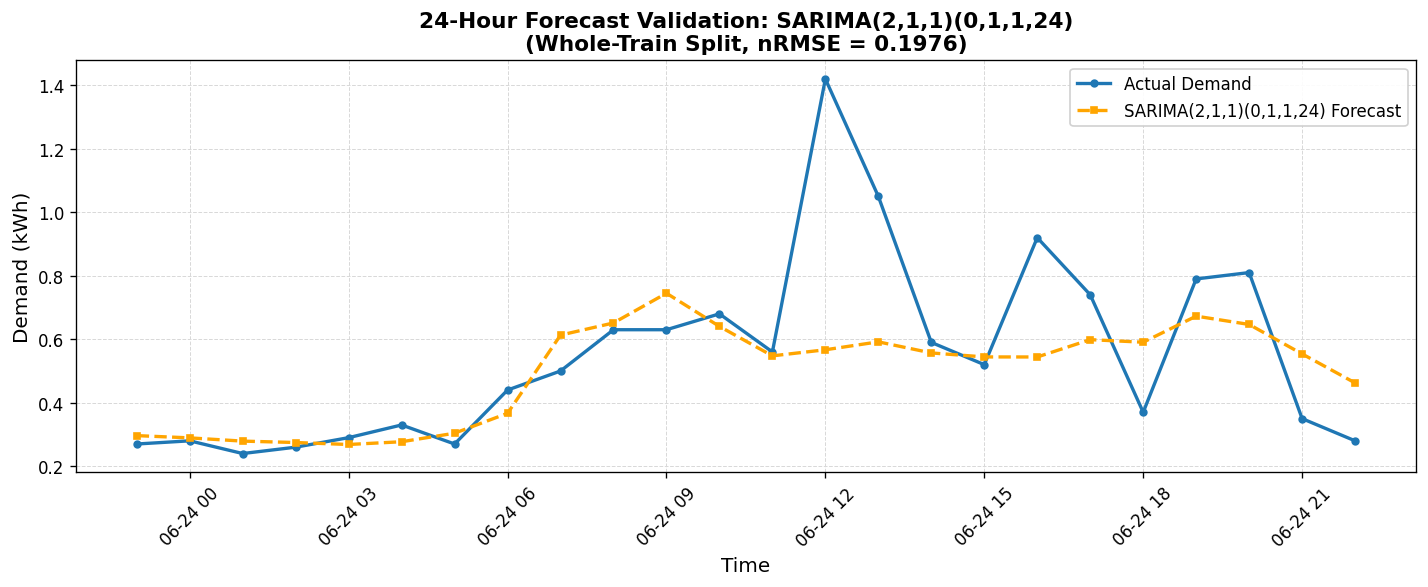

In [9]:

best_model_name = single_split_metrics.sort_values("nRMSE").iloc[0]["model_name"]
best_nrmse = single_split_metrics.sort_values("nRMSE").iloc[0]["nRMSE"]
print(f"Best model (whole-train nRMSE): {best_model_name} with nRMSE = {best_nrmse:.4f}")

best_single_split = single_split_predictions_df[single_split_predictions_df["model_name"] == best_model_name]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(best_single_split['timestamp'], best_single_split['y_true'], 
        color=COLORS['actual'], linewidth=2, label='Actual Demand', marker='o', markersize=4)
ax.plot(best_single_split['timestamp'], best_single_split['y_pred'], 
        color=COLORS['sarima1'], linewidth=2, label=f'{best_model_name} Forecast', 
        linestyle='--', marker='s', markersize=4)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Demand (kWh)', fontsize=12)
ax.set_title(f'24-Hour Forecast Validation: {best_model_name}\n(Whole-Train Split, nRMSE = {best_nrmse:.4f})', 
             fontsize=13, fontweight='semibold')
ax.legend(loc='upper right', fontsize=10)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
save_figure(fig, "07_forecast_overlay")
plt.show()

Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/07_walkforward_panels.png


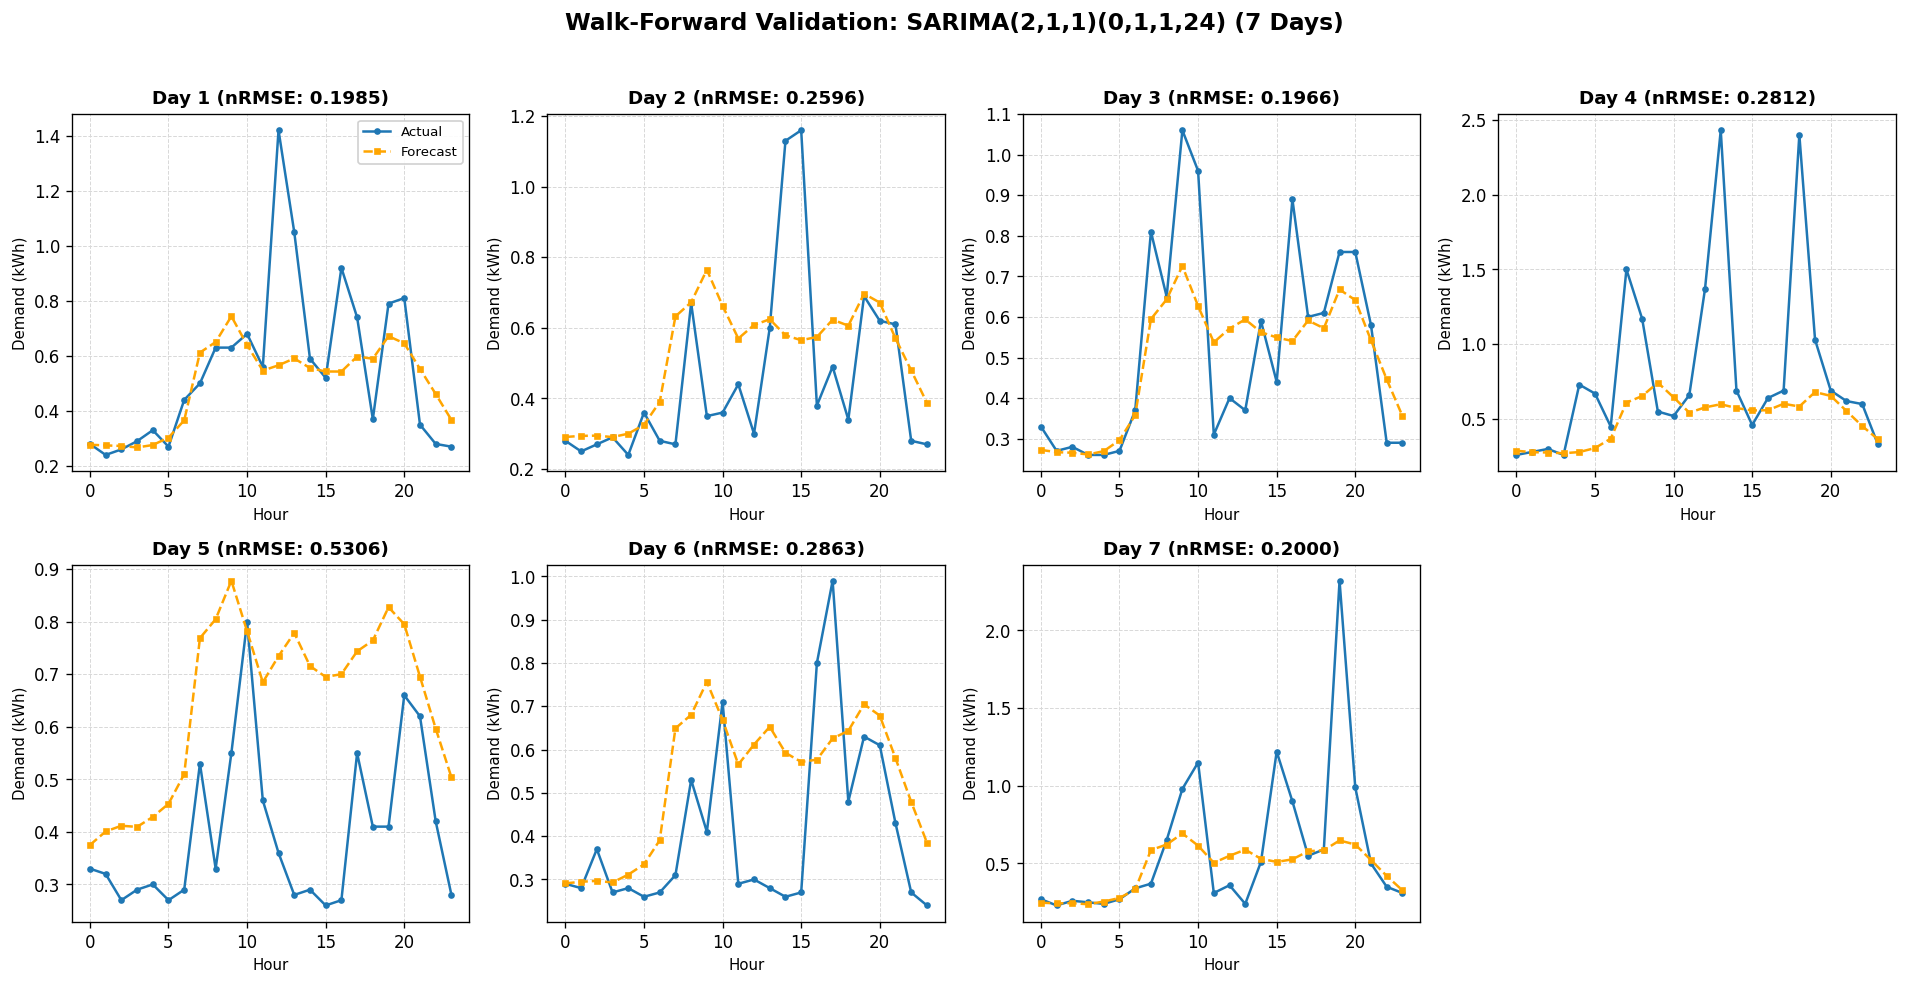

In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# Figure 2: Walk-Forward Validation Panels (7 Days)
# ─────────────────────────────────────────────────────────────────────────────
best_wf = walkforward_predictions_df[walkforward_predictions_df["model_name"] == best_model_name]
n_days = best_wf['day_idx'].nunique()

if n_days > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, day_idx in enumerate(sorted(best_wf['day_idx'].unique())):
        if i >= 7:
            break
        day_data = best_wf[best_wf['day_idx'] == day_idx]
        day_metrics = walkforward_metrics_df[
            (walkforward_metrics_df['day_idx'] == day_idx) & 
            (walkforward_metrics_df['model_name'] == best_model_name)
        ]
        
        ax = axes[i]
        hours = range(len(day_data))
        ax.plot(hours, day_data['y_true'].values, color=COLORS['actual'], 
                linewidth=1.5, label='Actual', marker='o', markersize=3)
        ax.plot(hours, day_data['y_pred'].values, color=COLORS['sarima1'], 
                linewidth=1.5, label='Forecast', linestyle='--', marker='s', markersize=3)
        
        if not day_metrics.empty:
            nrmse = day_metrics['nRMSE'].values[0]
            ax.set_title(f'Day {day_idx} (nRMSE: {nrmse:.4f})', fontsize=11)
        else:
            ax.set_title(f'Day {day_idx}', fontsize=11)
        
        ax.set_xlabel('Hour', fontsize=9)
        ax.set_ylabel('Demand (kWh)', fontsize=9)
        if i == 0:
            ax.legend(fontsize=8, loc='upper right')
    
    # Hide the 8th subplot if only 7 days
    if n_days < 8:
        axes[7].axis('off')
    
    fig.suptitle(f'Walk-Forward Validation: {best_model_name} (7 Days)', 
                 fontsize=14, fontweight='semibold', y=1.02)
    plt.tight_layout()
    save_figure(fig, "07_walkforward_panels")
    plt.show()
else:
    print("No walk-forward predictions available for visualization.")

Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/07_metrics_comparison.png


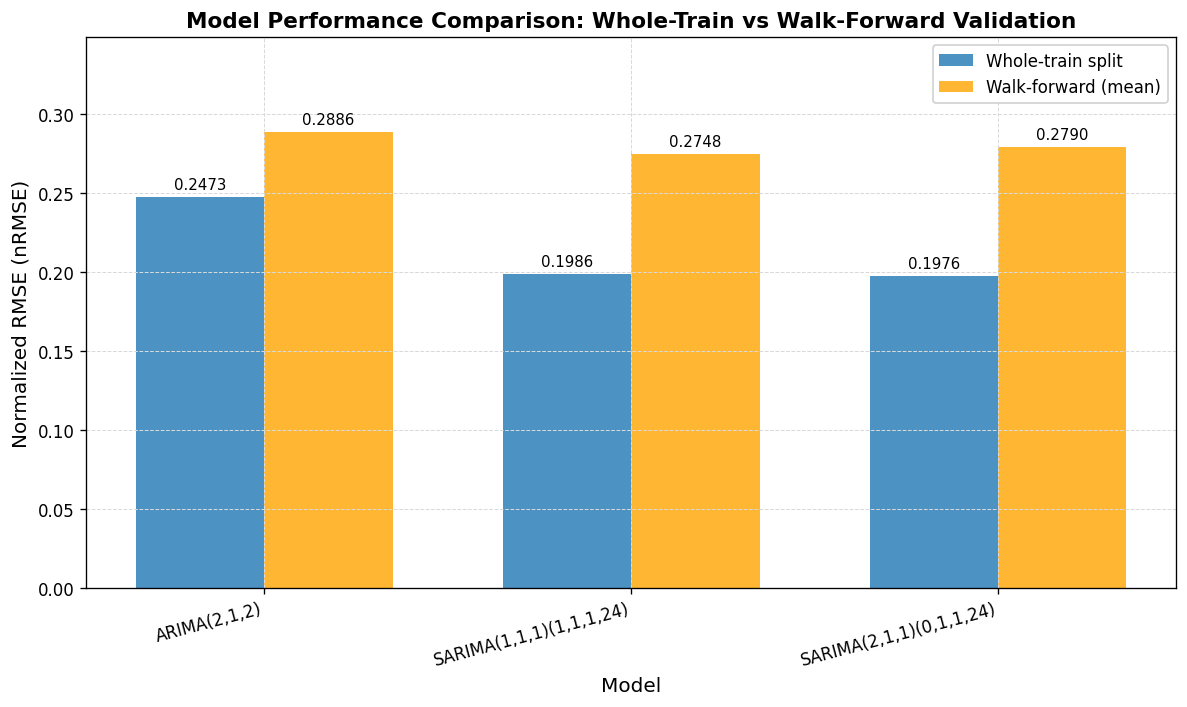

Summary Metrics Comparison:


evaluation,Walk-forward (mean),Whole-train split
model_name,,
"ARIMA(2,1,2)",0.288600,0.247271
"SARIMA(1,1,1)(1,1,1,24)",0.274795,0.198615
"SARIMA(2,1,1)(0,1,1,24)",0.278979,0.197627


In [11]:

# Merge metrics for bar chart (whole split + walk-forward mean)
if not walkforward_metrics_df.empty:
    walkforward_summary = (
        walkforward_metrics_df.groupby("model_name")[["MAE", "RMSE", "nRMSE"]]
        .mean()
        .reset_index()
    )
    walkforward_summary["evaluation"] = "Walk-forward (mean)"
else:
    walkforward_summary = pd.DataFrame(columns=["model_name", "MAE", "RMSE", "nRMSE", "evaluation"])

whole_split_metrics = single_split_metrics[["model_name", "MAE", "RMSE", "nRMSE"]].copy()
whole_split_metrics["evaluation"] = "Whole-train split"

metrics_combined = pd.concat([whole_split_metrics, walkforward_summary], ignore_index=True)

# Create grouped bar chart for nRMSE comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = metrics_combined['model_name'].unique()
evaluations = metrics_combined['evaluation'].unique()
x = np.arange(len(models))
width = 0.35

colors = [COLORS['actual'], COLORS['sarima1']]

for i, eval_type in enumerate(evaluations):
    subset = metrics_combined[metrics_combined['evaluation'] == eval_type]
    nrmse_values = [subset[subset['model_name'] == m]['nRMSE'].values[0] 
                    if m in subset['model_name'].values else 0 for m in models]
    bars = ax.bar(x + i * width, nrmse_values, width, label=eval_type, color=colors[i], alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, nrmse_values):
        if not np.isnan(val):
            ax.annotate(f'{val:.4f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Normalized RMSE (nRMSE)', fontsize=12)
ax.set_title('Model Performance Comparison: Whole-Train vs Walk-Forward Validation', 
             fontsize=13, fontweight='semibold')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(0, ax.get_ylim()[1] * 1.15)

plt.tight_layout()
save_figure(fig, "07_metrics_comparison")
plt.show()

# Display summary table
print("Summary Metrics Comparison:")
display(metrics_combined.pivot_table(index='model_name', columns='evaluation', values='nRMSE'))

## Export Metrics Tables

In [12]:
# Save all metrics tables
stationarity_combined.to_csv(TABLE_PATH / "stationarity_tests.csv", index=False)
single_split_metrics.to_csv(TABLE_PATH / "model_candidates_metrics.csv", index=False)
walkforward_metrics_df.to_csv(TABLE_PATH / "walkforward_per_day_metrics.csv", index=False)
walkforward_summary.to_csv(TABLE_PATH / "walkforward_metrics_summary.csv", index=False)
metrics_combined.to_csv(TABLE_PATH / "stats_metrics_comparison.csv", index=False)
